In [1]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from kymatio import Scattering2D
from phase_scattering2d_torch import ScatteringTorch2D_wph
from models.ISTC import ISTC
from models.Rescaling import Rescaling
from models.LinearProj import LinearProj
from models.Classifier import Classifier
from models.SparseScatNet import SparseScatNet

from torch.utils.tensorboard import SummaryWriter
from utils import print_and_write, compute_stding_matrix

import numpy as np 
import matplotlib.pyplot as plt

# GPU or CPU

In [2]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Define the model based on the different parameteres 

## Model parameters : based on the parser

# Load the saved model

In [3]:
! ls 

LICENSE			      model_analysis.ipynb
README.md		      models
__pycache__		      phase_scattering2d_torch.py
checkpoints		      run_from_cluster.ipynb
checkpoints_sparsescatnet     sparsescatnet_logs
checkpoints_sparsescatnet_16  sparsescatnet_logs_16
cmd.txt			      standardization
convergence_analysis.ipynb    training_logs
convergence_analysis.py       utils.py
main.py			      utils_sampling


In [4]:
! ls checkpoints_sparsescatnet_16

sparsescatnet_batchsize_256_lrfreq_60.pth.tar
sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar


In [5]:
model_path = "checkpoints_sparsescatnet_16/sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar"

In [6]:
loaded_dict = torch.load(model_path)

In [7]:
loaded_dict.keys()

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc1', 'optimizer'])

In [8]:
loaded_dict["optimizer"].keys()

dict_keys(['state', 'param_groups'])

In [9]:
best_epoch = loaded_dict["epoch"]

In [10]:
loaded_dict["state_dict"].keys()

odict_keys(['module.scattering.0.tensor0', 'module.scattering.0.tensor1', 'module.scattering.0.tensor2', 'module.scattering.0.tensor3', 'module.scattering.0.tensor4', 'module.scattering.0.tensor5', 'module.scattering.0.tensor6', 'module.scattering.0.tensor7', 'module.scattering.0.tensor8', 'module.scattering.0.tensor9', 'module.scattering.0.tensor10', 'module.scattering.0.tensor11', 'module.scattering.0.tensor12', 'module.scattering.0.tensor13', 'module.scattering.0.tensor14', 'module.scattering.0.tensor15', 'module.scattering.0.tensor16', 'module.scattering.0.tensor17', 'module.scattering.0.tensor18', 'module.scattering.0.tensor19', 'module.scattering.0.tensor20', 'module.scattering.0.tensor21', 'module.scattering.0.tensor22', 'module.scattering.0.tensor23', 'module.scattering.0.tensor24', 'module.scattering.0.tensor25', 'module.scattering.0.tensor26', 'module.scattering.0.tensor27', 'module.scattering.0.tensor28', 'module.scattering.0.tensor29', 'module.scattering.0.tensor30', 'modul

## Let's analyse the weights of the dictionnary of ISTC

In [11]:
istc_dictionary_weight = loaded_dict["state_dict"]["module.istc.dictionary_weight"]

In [12]:
istc_dictionary_weight.size()

torch.Size([256, 2048, 1, 1])

##  convert the 4D tensor to a 2D tensor

In [13]:
istc_dictionary_weight = istc_dictionary_weight.view(istc_dictionary_weight.size()[0], 
                                                     istc_dictionary_weight.size()[1])

In [14]:
istc_dictionary_weight.size()

torch.Size([256, 2048])

In [15]:
istc_dictionary_weight[0].size()

torch.Size([2048])

## Visualisations of the dictionnary

In [16]:
dict_as_numpy = istc_dictionary_weight.cpu().numpy()

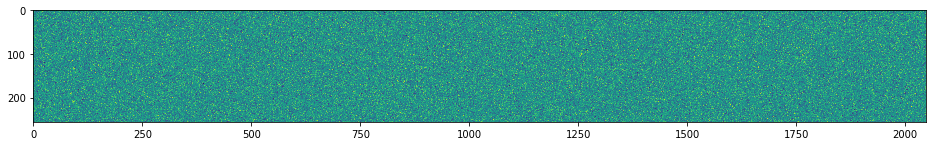

In [17]:
plt.figure(figsize=(16,12))
plt.imshow(dict_as_numpy)
plt.show()

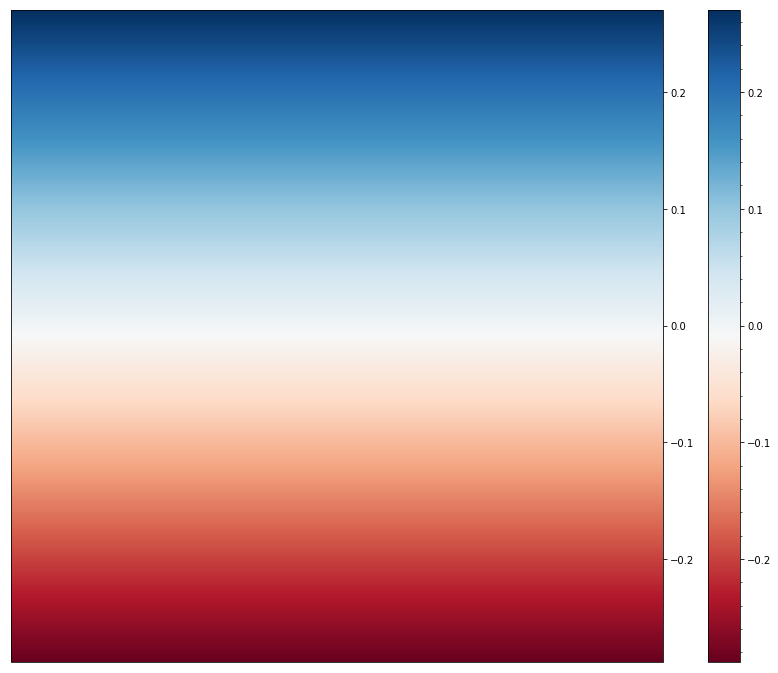

In [18]:
fig, ax = plt.subplots(figsize = (16,12))
pos = ax.imshow(dict_as_numpy, cmap='RdBu')
fig.colorbar(pos, ax)
cbar = fig.colorbar(pos, ax=ax)
cbar.minorticks_on()
plt.show()

In [19]:
all_values = istc_dictionary_weight.view(-1).cpu().numpy()

In [20]:
all_values.shape

(524288,)

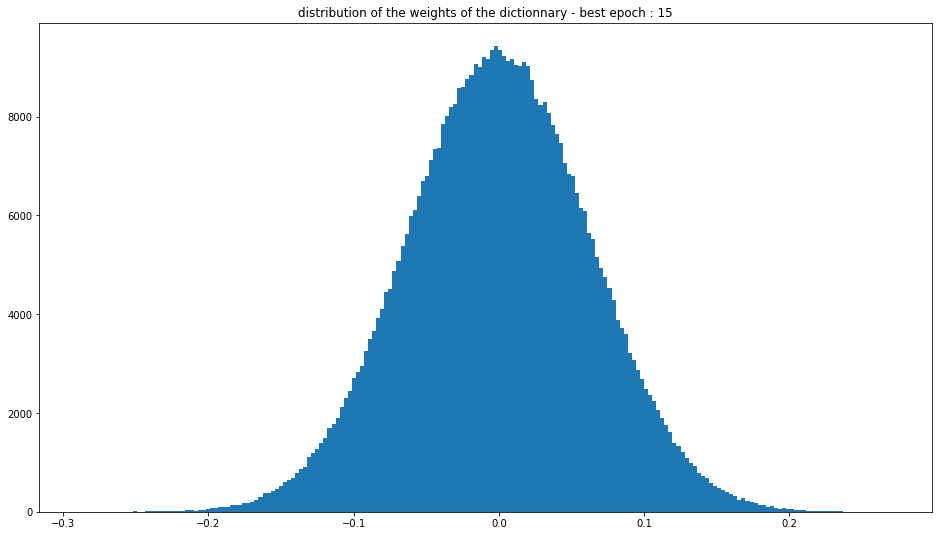

In [21]:
plt.figure(figsize=(16,9))
plt.hist(all_values, bins=200)
plt.title(f"distribution of the weights of the dictionnary - best epoch : {best_epoch}")
plt.show()

# Results of every layer

In [22]:
## python3 main.py -a sparsescatnet -p 100 --scattering-J 4 --scattering-order2 --scattering-wph --L-kernel-size 3 --dictionary-size 2048 --L-proj-size 256 --epochs 20 --learning-rate-adjust-frequency 60 --lr 0.01 --lambda-star 0.05 --grad-lambda-star --lambda-star-lb 0.05 --l0-inf-init --epsilon-lambda-0 1 --logdir ./sparsescatnet_logs --n-iterations 12  --classifier-type mlp --nb-l-mlp 2 --dropout-p-mlp 0.3 --nb-hidden-units 4096 --avg-ker-size 3 --savedir ./checkpoints_sparsescatnet -j 10  ~/Datasets/ImageNet/ILSVRC/Data/CLS-LOC

In [23]:
model_names = ['sparsescatnet', 'sparsescatnetw', 'scatnet']

NEW_IMAGE_SIZE = 16

arch               = "sparsescatnet"
scattering_J       = 4
scattering_order2  = True
scat_angles        = 8
scattering_wph     = True
scattering_nphases = 4
nb_classes         = 1000 
L_proj_size        = 256
L_kernel_size      = 3
n_iterations       = 12
dictionary_size    = 2048
classifier_type    = "mlp"
lambda_0           = 0.3
lambda_star        = 0.05
lambda_star_lb     = 0.05
grad_lambda_star   = True
epsilon_lambda_0   = 1
output_rec         = False
nb_hidden_units    = 4096
nb_l_mlp           = 2
dropout_p_mlp      = 0.3
avg_ker_size       = 3
BS                 = 256
workers            = 10

## Model creation

In [24]:
if arch in model_names:
    n_space = NEW_IMAGE_SIZE
    nb_channels_in = 3

    # create scattering
    J = scattering_J
    L_ang = scat_angles

    max_order = 2 if scattering_order2 else 1

    if scattering_wph:
        A = scattering_nphases
        scattering = ScatteringTorch2D_wph(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, A=A, 
                                           max_order=max_order)                                    
    else:
        scattering = Scattering2D(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, 
                                  max_order=max_order)
    # Flatten scattering
    scattering = nn.Sequential(scattering, nn.Flatten(1, 2))

    if scattering_wph:
        nb_channels_in += 3 * A * L_ang * J
    else:
        nb_channels_in += 3 * L_ang * J

    if max_order == 2:
        nb_channels_in += 3 * (L_ang ** 2) * J * (J - 1) // 2

    n_space = n_space // (2 ** J)
###########################################################################################
    
    std_file = 'standardization/ImageNet2012_scattering_J{}_order{}_wph_{}_nphases_{}_nb_classes_{}.pth.tar'.format(
        scattering_J, 2 if scattering_order2 else 1, scattering_wph,
        scattering_nphases if scattering_wph else 0, nb_classes)

    # compute the mean and the std of the data
    if os.path.isfile(std_file):
        std_dict = torch.load(std_file)
        mean_std = std_dict['mean']
        stding_mat = std_dict['matrix']
    else:
        print("standirisation file not found")

    standardization = Rescaling(mean_std, stding_mat)
    
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        proj = nn.Conv2d(nb_channels_in, L_proj_size, kernel_size=L_kernel_size, stride=1,
                         padding=0, bias=False)
        nb_channels_in = L_proj_size
        linear_proj = LinearProj(standardization, proj, L_kernel_size)
    else:  # scatnet
        proj = nn.Identity()
        linear_proj = LinearProj(standardization, proj, 0)

    ###########################################################################################

    # Create ISTC (when applicable)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
    ###########################################################################################
        if arch == 'sparsescatnet':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec)

        elif arch == 'sparsescatnetw':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec, use_W=True)

        if not output_rec:
            nb_channels_in = dictionary_size

    elif arch == 'scatnet':
        print("=> creating model ScatNet with phase scattering {} and classifier {}".\
            format(scattering_wph, classifier_type))

    # Create classifier
    ###########################################################################################
    classifier = Classifier(n_space, nb_channels_in, classifier_type=classifier_type,
                            nb_classes=1000, nb_hidden_units=nb_hidden_units, nb_l_mlp=nb_l_mlp,
                            dropout_p_mlp=dropout_p_mlp, avg_ker_size=avg_ker_size)

    # Create model
    ###########################################################################################
    #model = SparseScatNet(scattering, linear_proj, istc, nn.Identity(), return_full_inf=False)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        model = SparseScatNet(scattering, linear_proj, istc, classifier, return_full_inf=True)  # print model info

    elif arch == 'scatnet':
        model = nn.Sequential(scattering, linear_proj, classifier)
else:
    print("not a valid model")

## Load the model

In [25]:
model_dict = model.state_dict()
checkpoint_dict = loaded_dict['state_dict']
checkpoint_dict = {k: v for k, v in checkpoint_dict.items() if k in model_dict}
model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
dictionary = model.istc.dictionary_weight.data
w_matrix   = model.istc.w_weight.data

In [26]:
# model to GPU and enable eval mode
model.cuda()
model.eval()

SparseScatNet(
  (scattering): Sequential(
    (0): ScatteringTorch2D_wph()
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (linear_proj): LinearProj(
    (standardization): Rescaling()
    (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (istc): ISTC()
  (classifier): Classifier(
    (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (classifier): Sequential(
      (0): Linear(in_features=2048, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=4096, out_features=4096, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
  )
)

## Load (val) data 

In [27]:
path_data = "~/Datasets/ImageNet/ILSVRC/Data/CLS-LOC"

valdir   = os.path.join(path_data, 'val')
    
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.Resize((NEW_IMAGE_SIZE, NEW_IMAGE_SIZE)),
                    transforms.ToTensor(),
                    normalize,
                ]))

val_dataset = torch.utils.data.Subset(val_dataset, range(100))

In [28]:
val_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False, 
                                          num_workers=workers, pin_memory=True)

have the loader as a iterable list

In [29]:
iter_val_loader = next(iter(val_loader))[0]

In [30]:
len(iter_val_loader)

100

In [31]:
n_examples = 3
input_test = iter_val_loader[0:n_examples].cuda()

### Scattering:

In [32]:
model.scattering

Sequential(
  (0): ScatteringTorch2D_wph()
  (1): Flatten(start_dim=1, end_dim=2)
)

In [33]:
scatt = model.scattering[0](input_test).view(-1, 3, 2*NEW_IMAGE_SIZE*NEW_IMAGE_SIZE + 1)[0,:,:].cpu().numpy()

/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:231: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  output = torch.fft(x, 2, normalized=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:226: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  output = torch.irfft(x, 2, normalized=False, onesided=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scatteri

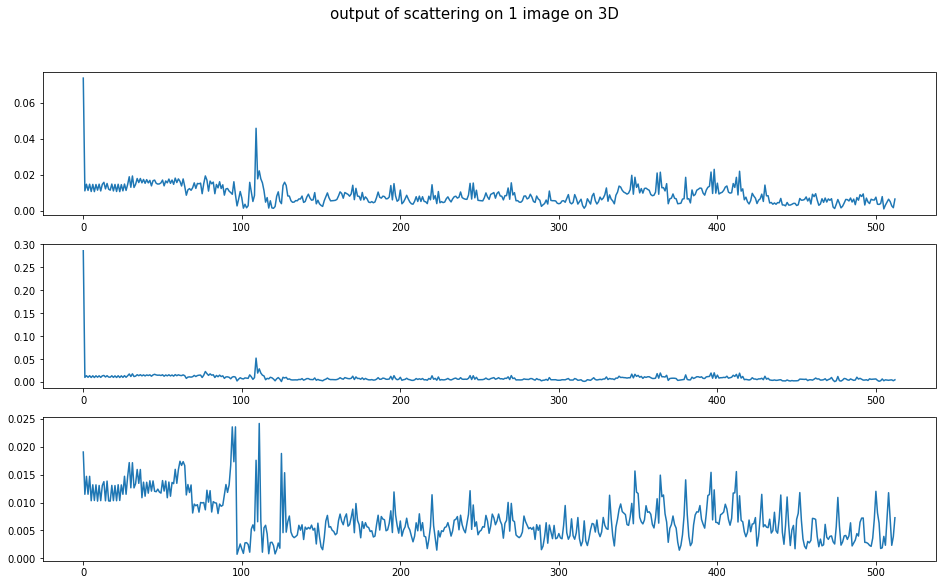

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,9))
fig.suptitle("output of scattering on 1 image on 3D", fontsize = 15)
ax1.plot(scatt[0,:])
ax2.plot(scatt[1,:])
ax3.plot(scatt[2,:])
plt.show()

In [35]:
out_scat = model.scattering(input_test.cuda())

In [36]:
out_scat.size()

torch.Size([3, 1539, 1, 1])

### Linear Projection:

In [37]:
model.linear_proj

LinearProj(
  (standardization): Rescaling()
  (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
)

In [38]:
lin_out = model.linear_proj(out_scat)

In [39]:
lin_out.size()

torch.Size([3, 256, 1, 1])

In [40]:
linp_p = lin_out.view(-1,L_proj_size)[0,:].cpu().detach().numpy()

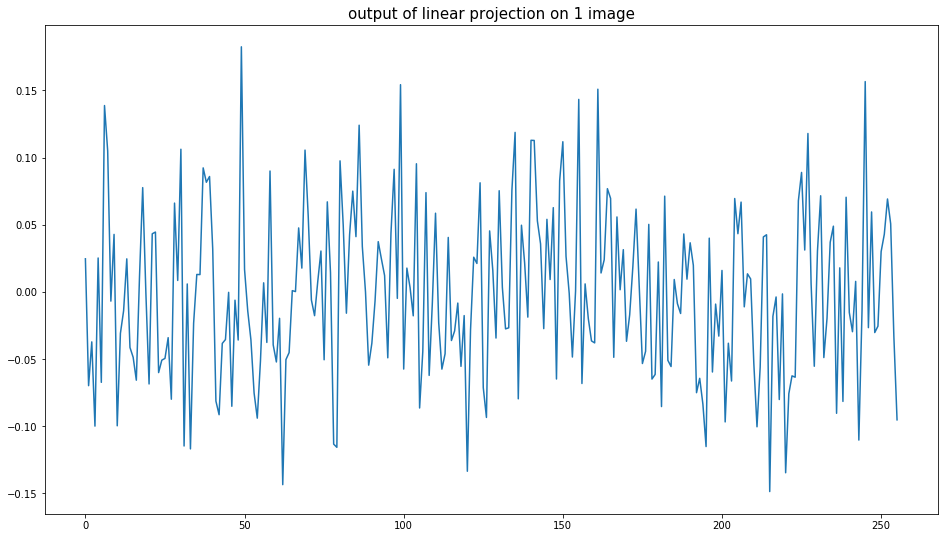

In [41]:
plt.figure(figsize=(16,9))
plt.plot(linp_p)
plt.title("output of linear projection on 1 image", fontsize=15)
plt.show()

### ISTC:

In [42]:
model.istc

ISTC()

In [43]:
istc_out = model.istc(lin_out)

In [44]:
istc_out.size()

torch.Size([3, 2048, 1, 1])

In [45]:
istc_arr = istc_out.view(-1,dictionary_size)[0,:].cpu().detach().numpy()

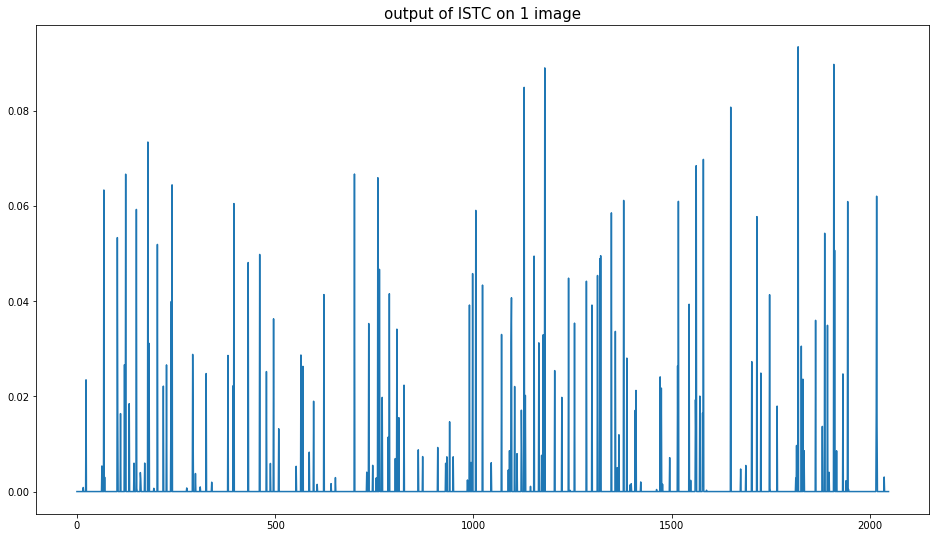

In [46]:
plt.figure(figsize=(16,9))
plt.plot(istc_arr)
plt.title("output of ISTC on 1 image", fontsize=15)
plt.show()

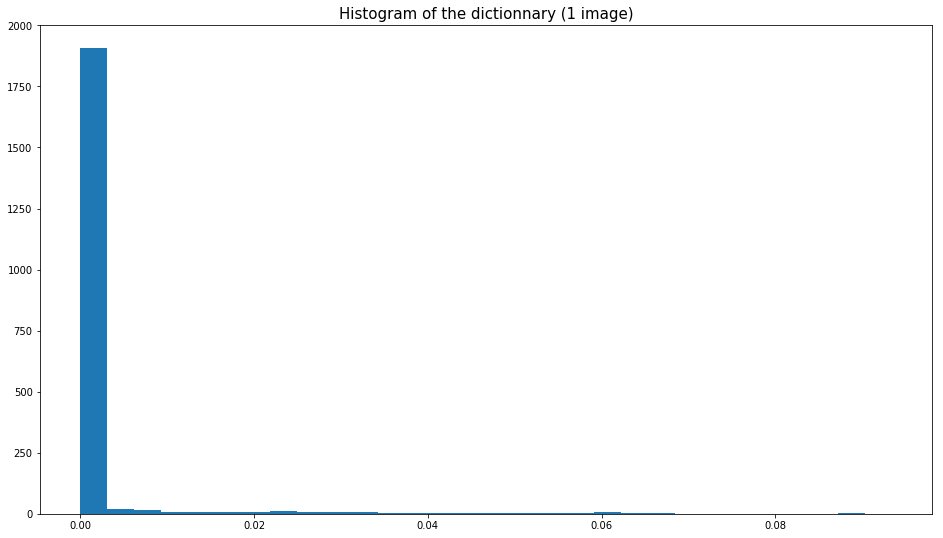

In [47]:
plt.figure(figsize=(16,9))
plt.hist(istc_arr, bins=30)
plt.title("Histogram of the dictionnary (1 image)", fontsize=15)
plt.show()

### Classifier:

In [48]:
model.classifier

Classifier(
  (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [49]:
clas_out = model.classifier(istc_out)

In [50]:
clas_out.size()

torch.Size([3, 1000])

In [51]:
torch.argmax(clas_out, dim=1)

tensor([181, 181, 181], device='cuda:0')